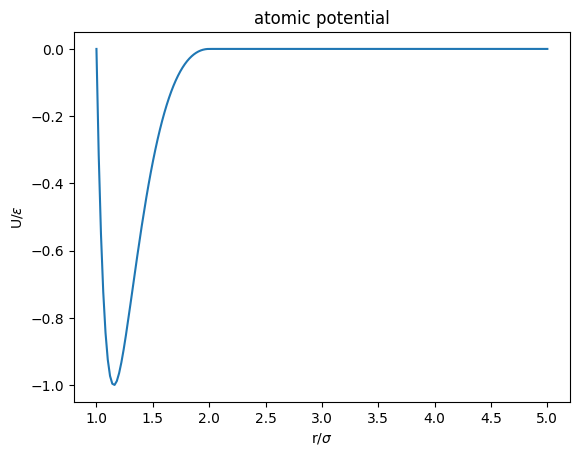

In [2]:
from itertools import combinations
from typing import Callable
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

def lj_potential(x: float) -> float:  # obfuscated, but fast implementation!
    r6 = 1 / x / x
    r6 *= r6 * r6
    return 4 * r6 * (r6 - 1)

def lj_potential_cut(x:float)->float:
    if x>=2.5:
        return 0
    else:
        return lj_potential(x)-lj_potential(2.5)


def pairwise_potential(potential: Callable[[float], float], xss: [[float]], box:float) -> float:
    """
    >>> lj13 = [
    ...     [  1.0132226417,  0.3329955686,  0.1812866397],
    ...     [   0.7255989775, -0.7660449415,  0.2388625373],
    ...     [   0.7293356067, -0.2309436666, -0.7649239428],
    ...     [   0.3513618941,  0.8291166557, -0.5995702064],
    ...     [   0.3453146118, -0.0366957540,  1.0245903005],
    ...     [   0.1140240770,  0.9491685999,  0.5064104273],
    ...     [  -1.0132240213, -0.3329960305, -0.1812867552],
    ...     [  -0.1140234764, -0.9491689127, -0.5064103454],
    ...     [  -0.3513615244, -0.8291170821,  0.5995701458],
    ...     [  -0.3453152548,  0.0366956843, -1.0245902691],
    ...     [  -0.7255983925,  0.7660457628, -0.2388624662],
    ...     [  -0.7293359733,  0.2309438428,  0.7649237858],
    ...     [   0.0000008339,  0.0000002733,  0.0000001488],
    ... ]
    >>> pairwise_potential(lj_potential, lj13)
    -44.326801418734654
    """
    
    Sum=0
    
    # box accounts for periodic boundary condition
    for xi,xj in combinations(xss,2):
        d=0
        for k in range(len(xi)):
            if xi[k]-xj[k]<-box/2:
                d+=(xi[k]+box-xj[k])**2
            elif xi[k]-xj[k]>box/2:
                d+=(xi[k]-box-xj[k])**2
            else:
                d+=(xi[k]-xj[k])**2
        Sum+=potential(d**0.5) 
    
    return Sum
    
def phi_A(r:float)->float:
    alpha=1
    rc=2.0
    r2=1/r**2
    if r>=rc:
        return 0
    else:
        return alpha*(r2-1)*(rc**2*r2-1)**2

def phi_A_derivative(r:float)->float:
    alpha=1
    rc=2.0
    r3=1/r**3
    rr=(rc/r)**2
    
    if r>=rc:
        return 0
    else:
        return 2*alpha*(rr-1)*(-3*rr+1+2*rc**2)
    

x=np.linspace(1,5,200)
fig, ax = plt.subplots()

ax.plot(x,[phi_A(i) for i in x])
ax.set_title("atomic potential")
ax.set_xlabel("r/$\sigma$")
ax.set_ylabel("U/$\epsilon$")
plt.savefig("phi_A.png")

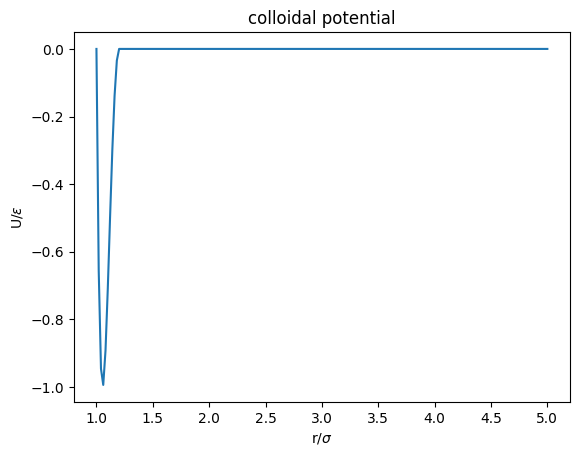

In [4]:
def phi_C(r:float)->float:
    alpha=114
    rc=1.2
    r2=1/r**2
    if r>=rc:
        return 0
    else:
        return alpha*(r2-1)*(rc**2*r2-1)**2
    
x=np.linspace(1,5,200)
fig, ax = plt.subplots()

ax.plot(x,[phi_C(i) for i in x])
ax.set_title("colloidal potential")
ax.set_xlabel("r/$\sigma$")
ax.set_ylabel("U/$\epsilon$")
plt.savefig("phi_C.png")

In [5]:
xi=[0,2,3]
xj=[2,5,6]
list(zip(xi,xj))
print(sum((xia-xja)**2 for xia, xja in zip(xi, xj)))

22


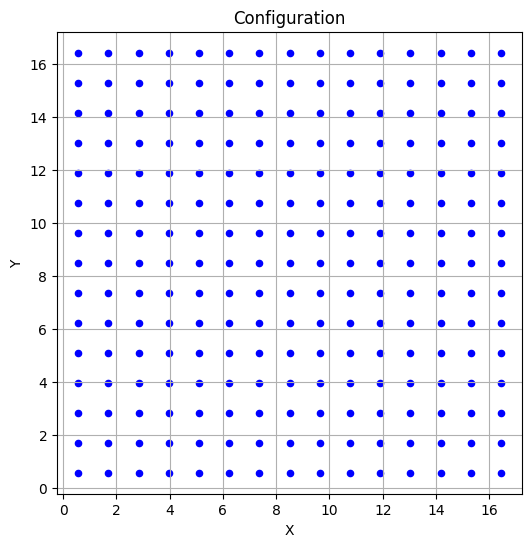

total atomic potential energy is: -530.725369443786
total colloidal potential energy is: -166.62489913545093
total LJ potential energy is: -539.6410195161218


In [31]:
def init_mc(rho:float,L:float,type:int)->np.ndarray:
    if type not in (0, 1):
        raise ValueError("Invalid value for 'type' parameter. It must be 0 or 1. 0 for random positions, 1 for ordered lattice")
    
    N = int(rho * L**2)
    n = int(np.sqrt(N))  
    
    if type==1:
        coordinates = np.zeros((n**2, 2))
        s = L / n
        shift=(L-(n-1)*s)/2

        k = 0
        for i in range(n):
            for j in range(n):
                coordinates[k] = [i * s+shift, j * s+shift]
                k += 1
                
        return coordinates
    
    if type==0:
        coordinates=np.zeros((N,2))
        count = 0
        while count < N:
            x = np.random.uniform(0, L)
            y = np.random.uniform(0, L)
            if count == 0:
                coordinates[count] = [x, y]
                count += 1
            else:
                distances = np.linalg.norm(coordinates[:count] - np.array([x, y]), axis=1)
                if np.all(distances >= 0.5):
                    #print(distances)
                    coordinates[count] = [x, y]
                    count += 1
                    
        return coordinates
        
def init_md(rho:float,L:float,T0:float,type:int)->list[np.ndarray]:
    if type not in (0, 1):
        raise ValueError("Invalid value for 'type' parameter. It must be 0 or 1. 0 for random positions, 1 for ordered lattice")
    
    N = int(rho * L**2)
    n = int(np.sqrt(N))  
    
    if type==1:
        coordinates = np.zeros((n**2, 2))
        s = L / n
        shift=(L-(n-1)*s)/2

        k = 0
        for i in range(n):
            for j in range(n):
                coordinates[k] = [i * s+shift, j * s+shift]
                k += 1
        
        velocities=np.zeros((n**2,2))
        for i in range(n**1):
            velocities[i][0]=np.random.normal(0, np.sqrt(T0))
            velocities[i][1]=np.random.normal(0, np.sqrt(T0))
        
        return [coordinates,velocities]
    
    if type==0:
        coordinates=np.zeros((N,2))
        velocities=np.zeros((N,2))
        
        count = 0
        while count < N:
            x = np.random.uniform(0, L)
            y = np.random.uniform(0, L)
            if count == 0:
                coordinates[count] = [x, y]
                velocities[count][0]=np.random.normal(0, np.sqrt(T0))
                velocities[count][1]=np.random.normal(0, np.sqrt(T0))
                count += 1
            else:
                distances = np.linalg.norm(coordinates[:count] - np.array([x, y]), axis=1)
                if np.all(distances >= 0.5):
                    #print(distances)
                    coordinates[count] = [x, y]
                    velocities[count][0]=np.random.normal(0, np.sqrt(T0))
                    velocities[count][1]=np.random.normal(0, np.sqrt(T0))
                    count += 1
                    
        return [coordinates,velocities]

def plot_configuration(coordinates: np.ndarray):
    plt.figure(figsize=(6, 6))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], color='b', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Configuration')
    plt.grid(True)
    plt.show()
    
def plot_list_values(lst,listname,xlabel,ylabel):
    plt.plot(range(len(lst)), lst)
    plt.xlabel(str(xlabel))
    plt.ylabel(str(ylabel))
    plt.title(str(listname))

T1=0.728
rho1=0.8442
T2=1
rho2=0.1
T3=5

box=10

init_config=init_mc(rho1,box,1)
plot_configuration(init_config)
components=np.zeros_like(init_config)

#print(init_config)
print("total atomic potential energy is:",pairwise_potential(phi_A,init_config,box))
print("total colloidal potential energy is:",pairwise_potential(phi_C,init_config,box))
print("total LJ potential energy is:",pairwise_potential(lj_potential_cut,init_config,box))

In [7]:
import math
from decimal import Decimal
import os


def my_remainder(a:float,b:float):
    dec_b=Decimal(str(b))
    remainder=Decimal(str(a))%Decimal(str(b))
    if remainder<0:
        return float(remainder+dec_b)
    return float(remainder)



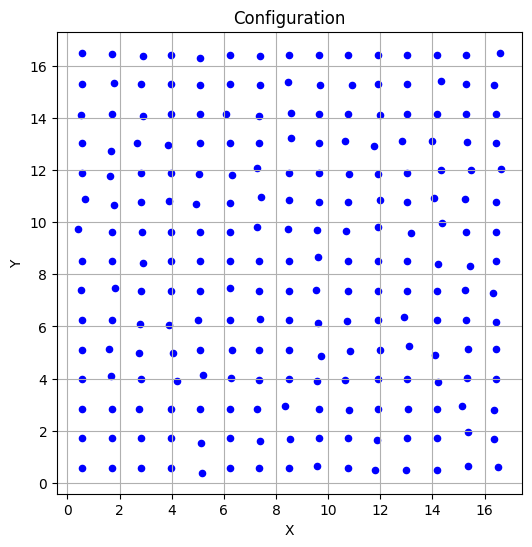

In [34]:
import random
from math import dist

def periodic_dist(a:np.ndarray,b:np.ndarray,box:float):
    dist=0
    for i in range(len(a)):
        if a[i]-b[i]<-box*0.5:
            dist+=(a[i]-b[i]+box)**2
        elif a[i]-b[i]>box*0.5:
            dist+= (a[i]-b[i]-box)**2
        else:
            dist+=(a[i]-b[i])**2

    return dist**0.5
        

def pairwise_potential_gradient(gradient: Callable[[float], float], box:float,xss:np.ndarray,gradient_components:np.ndarray) -> np.ndarray:
    """
    calculate the gradient of the total pairwise energy w.r.t. the particle coordinates.
    
    :param gradient: computes the magnitude of the gradient for a single pair
    :param xss: n x d array of particle coordinates
    :return: n x d array of the derivative of the total energy w.r.t. particle coordinates
    """
    
    n, d = xss.shape
    
    for i in range(n):
        for alpha in range(d):
            sum=0
            for j in range(n):
                if j!=i:
                    distance=periodic_dist(xss[i],xss[j],box)
                    if xss[i,alpha]-xss[j,alpha]<-box*0.5:
                        sum+=(xss[i,alpha]-xss[j,alpha]+box)/distance*gradient(distance)
                    elif xss[i,alpha]-xss[j,alpha]>box*0.5:
                        sum+=(xss[i,alpha]-xss[j,alpha]-box)/distance*gradient(distance)
                    else:
                        sum+=(xss[i,alpha]-xss[j,alpha])/distance*gradient(distance)
            gradient_components[i][alpha]=sum
            
    return gradient_components

def velocity_verlet(t_step:float,x:np.ndarray,v:np.ndarray,f_old:np.ndarray,f_new:np.ndarray,box:float,potential_gradient:Callable[[float],float]):
    f_old=-pairwise_potential_gradient(potential_gradient,box,x,f_old)
    
    n,d=x.shape
    
    for i in range(n):
        for j in range(d):
            x[i][j]=my_remainder(x[i][j]+v[i][j]*t_step+0.5*f_old[i][j]*t_step**2,box)
            
    f_new=-pairwise_potential_gradient(potential_gradient,box,x,f_new)
    v=v+(f_old+f_new)*0.5*t_step
    
def anderson(T:float,velocities:np.ndarray):
    N=velocities.shape[0]
    rand_index=np.random.randint(0, N)
    velocities[rand_index][0]=np.random.normal(0, np.sqrt(T))
    velocities[rand_index][1]=np.random.normal(0, np.sqrt(T))

def md_simulation(t_step:float,total_step:int,T:float,box:float,interval:float,coordinates:np.ndarray,velocities:np.ndarray):
    N=coordinates.shape[0]
    energies=list(range(total_step))
    f_old=np.zeros_like(velocities)
    f_new=np.zeros_like(velocities)
    
    step=0
    while step<total_step:
        flag=0

        count_before_collision=np.random.poisson(interval)
        for j in range(count_before_collision):
            energies[step]=pairwise_potential(phi_A,coordinates,box)
            velocity_verlet(t_step,coordinates,velocities,f_old,f_new,box,phi_A_derivative)
            step+=1
            if step==total_step:
                flag=1
                break
        if flag==1:
            break
            
        #anderson(T,velocities)

    plot_configuration(coordinates)
    return energies


def mc_simulation(total_step:int,T:float,box:float,sigma:float, coordinates: np.ndarray):
    # T is the temparature; sigma is the magnitude of random displacement
    N=coordinates.shape[0]
    energies=list(range(total_step))
    
    for i in range(total_step):
        e_old=pairwise_potential(phi_A,coordinates,box)
        rand_index=np.random.randint(0, N)
        displace_x=np.random.normal(0, sigma)
        displace_y=np.random.normal(0, sigma)
        coordinates[rand_index][0]=my_remainder((coordinates[rand_index][0]+displace_x),box)
        coordinates[rand_index][1]=my_remainder((coordinates[rand_index][1]+displace_y),box)
        e_new=pairwise_potential(phi_A,coordinates,box)
        
        random_number = random.random()   
        if random_number<np.exp(-(e_new-e_old)/T):
            energies[i]=e_new
        else:
            energies[i]=e_old
            coordinates[rand_index][0]=my_remainder((coordinates[rand_index][0]-displace_x),box)
            coordinates[rand_index][1]=my_remainder((coordinates[rand_index][1]-displace_y),box)
            
        
    plot_configuration(coordinates)
    return energies

total_step=5000
energies=mc_simulation(total_step,T1,box,0.5,init_config)



In [ ]:
energies_md=md_simulation(0.013, 5000,T1,box,3,init_config,init_v)
print(energies_md)

-492.5467353921775
-492.5467353921775
-2.189096601743011
418.80296560860006
-0.04154869898439373


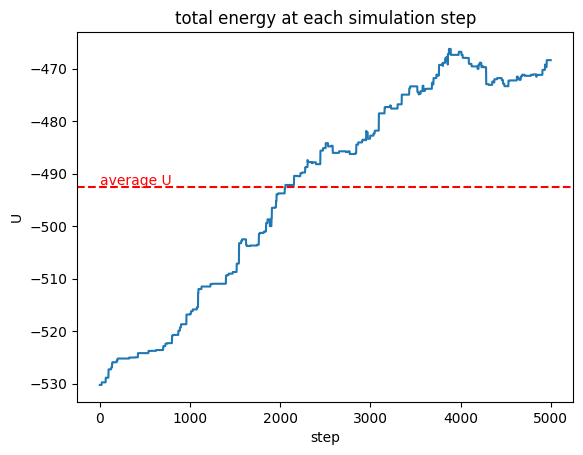

In [35]:
energies_trunc=energies[0:]
plot_list_values(energies_trunc,"total energy at each simulation step","step","U")
length = len(energies_trunc)
ave_energy=sum(energies_trunc)/length
plt.axhline(y=ave_energy, color='red', linestyle='--')
plt.text(0, ave_energy+0.5, 'average U', color='red')
print(ave_energy)


ave_energy_trunc=sum(energies_trunc)/len(energies_trunc)
print(ave_energy_trunc)
print(ave_energy_trunc/init_config.shape[0])
squared_energies_trunc = list(map(lambda x: x**2, energies_trunc))
fluc_energy=sum(squared_energies_trunc)/len(energies_trunc)-ave_energy_trunc**2
print(fluc_energy)
print(fluc_energy**0.5/ave_energy_trunc)

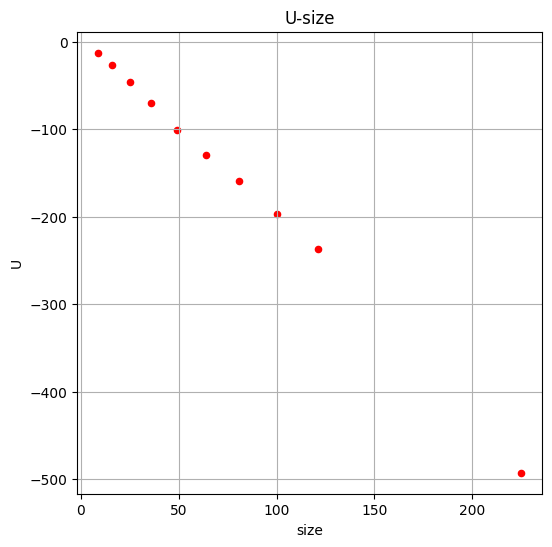

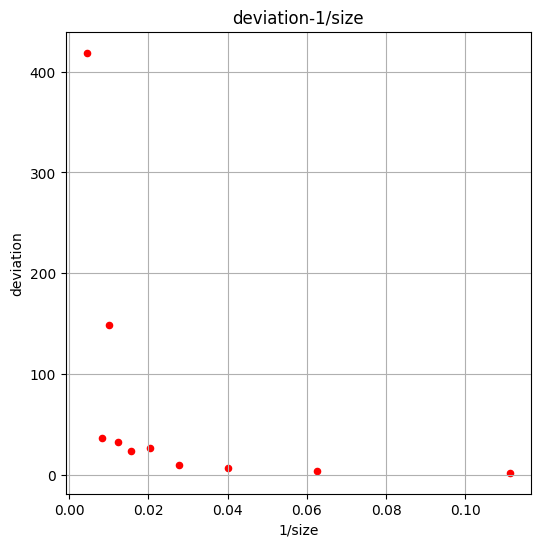

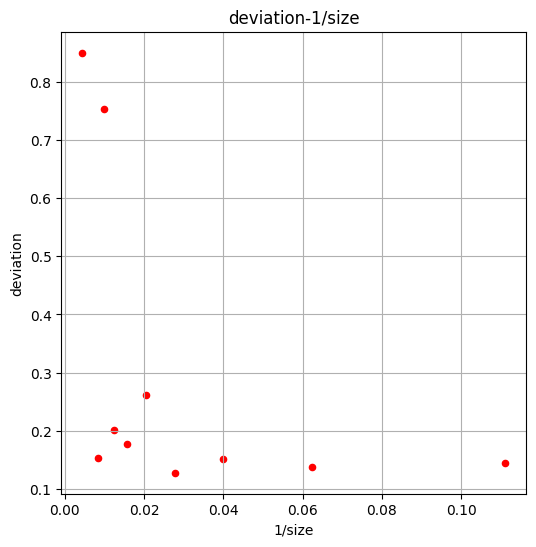

In [48]:
size=[9,25,16,36,49,64,81,100,121,225]
U=[-12.792,-45.938,-26.735,-70.667,-100.504,-129.624,-159.867,-197.440,-237.425,-492.546]
deviation=[1.850,6.962,3.664,9.020,26.248,22.964,32.040,148.627,36.383,418.802]
plt.figure(figsize=(6, 6))
plt.scatter(np.array(size), U, color='r', s=20)
plt.xlabel('size')
plt.ylabel('U')
plt.title('U-size')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(1/np.array(size), deviation, color='r', s=20)
plt.xlabel('1/size')
plt.ylabel('deviation')
plt.title('deviation-1/size')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(1/np.array(size), [-deviation[i]/U[i] for i in range(len(U))], color='r', s=20)
plt.xlabel('1/size')
plt.ylabel('deviation')
plt.title('deviation-1/size')
plt.grid(True)
plt.show()

-125.84720247778613
-125.84720247778613
-1.5536691663924214
263.1181176414284
-0.12889373569656665


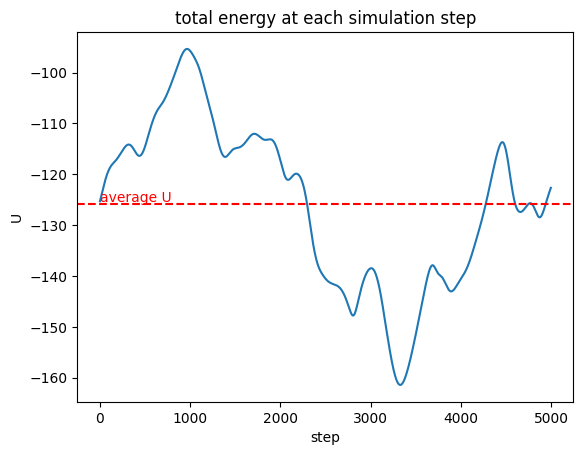

In [480]:
energies_md_trunc=energies_md[0:]
plot_list_values(energies_md_trunc,"total energy at each simulation step","step","U")
length = len(energies_md_trunc)
ave_energy=sum(energies_md_trunc)/length
plt.axhline(y=ave_energy, color='red', linestyle='--')
plt.text(0, ave_energy+0.5, 'average U', color='red')
print(ave_energy)


ave_energy_trunc=sum(energies_md_trunc)/len(energies_md_trunc)
print(ave_energy_trunc)
print(ave_energy_trunc/init_config.shape[0])
squared_energies_trunc = list(map(lambda x: x**2, energies_md_trunc))
fluc_energy=sum(squared_energies_trunc)/len(energies_md_trunc)-ave_energy_trunc**2
print(fluc_energy)
print(fluc_energy**0.5/ave_energy_trunc)

-1.272
